# Obtaining Data using Google API

In this notebook, we'll use Google API to gather data for the Comparis neighborhood score project.

We'll write a function that, given an address, returns data on the facilities in 10 min walking distance. The output includes the following information for each place in the results:

- place_id
- name
- rating
- num_ratings
- vicinity (address)
- location (latitude and longtitude)
- reviews (including info and texts)
- num_reviews
- url
- travel time (by walking)

For each given address, our function returns the number of facilities in 10 min walking distance for the following facility types. Moreover, using travel time, we determine the closest facility in each case.

- school
- hospital
- supermarket
- train_station
- movie_theater
- restaurant
- cafe
- gas_station
- parking
- park

*Disclaimer: Using Google's API services is not free, and the following code should be run only if you have an available API key.*

In [1]:
import requests
import json
import time
from itertools import islice

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
with open('credentials.json') as f:
    api_key = json.load(f)['google_key']

In [3]:
def get_coordinates(address):
    """
    Returns the coordinates (latitude and longitude) for a given address.
    """
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        location = data['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    return None

In [4]:
def get_travel_times(origin, destinations):
    """
    Returns the travel times by walking from the origin to multiple destinations.

    origin: Coordinates of the origin address
    destinations: List of coordinates of destination addresses
    """
    # Split destinations into chunks of 25 (API limit)
    def chunks(data, chunk_size):
        it = iter(data)
        return iter(lambda: tuple(islice(it, chunk_size)), ())
    
    all_travel_times = []
    
    for dest_chunk in chunks(destinations, 25):
        destinations_str = "|".join([f"{lat},{lng}" for lat, lng in dest_chunk])
        url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin[0]},{origin[1]}&destinations={destinations_str}&mode=walking&key={api_key}"
        response = requests.get(url)
        data = response.json()

        if data['status'] == 'OK':
            for element in data['rows'][0]['elements']:
                if element['status'] == 'OK':
                    all_travel_times.append(element['duration']['text'])
                else:
                    all_travel_times.append('Travel time not available')
        else:
            all_travel_times.extend(['Travel time not available'] * len(dest_chunk))

    return all_travel_times

In [5]:
def parse_time(time_str):
    """
    Parses a time string and returns the number of minutes.
    """
    if time_str == 'Travel time not available':
        return float('inf')  # If not available, treat as infinitely far
    parts = time_str.split()
    if len(parts) == 2:  # Format: "X mins"
        return int(parts[0])
    elif len(parts) == 4:  # Format: "X hours Y mins"
        return int(parts[0]) * 60 + int(parts[2])
    else:
        return float('inf')  # Unable to parse, treat as infinitely far

In [6]:
TIME_BOUND = 10 # minutes
RADIUS_BOUND = 2000 # meters

FACILITY_TYPES = {
    "bars": ["bar"],
    "restaurants": ["restaurant"],
    "kindergarten": [
        "preschool",
        "child_care_agency"
    ],
    "public_transportation": [
        "bus_station",
        "bus_stop",
        "light_rail_station",
        "subway_station",
        "train_station",
        "transit_station"
    ],
    "gym_fitness": [
        "fitness_center",
        "gym"]
    ,
    "grocery_stores_supermarkets": [
        "grocery_store",
        "supermarket"
    ],
    "gas_ev_charging": [
        "gas_station",
        "electric_vehicle_charging_station"
    ],
    "schools": [
        "primary_school",
        "secondary_school",
        "university"
    ]
}

In [7]:
def get_nearby_facilities(location, facility_type, travel_time_bound=TIME_BOUND, radius=RADIUS_BOUND):
    """
    Returns data on nearby facilities including travel times

    location: Coordinates of an address
    facility_type: schools, hospitals etc
    radius: search area in meters

    Returns a list of dictionaries
    """
    facilities = []
    url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location[0]},{location[1]}&radius={radius}&type={facility_type}&key={api_key}"
    
    while True:
        response = requests.get(url)
        data = response.json()
        
        current_facilities = []
        destinations = []
        
        for place in data.get('results', []):
            place_id = place['place_id']
            details_url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id}&fields=rating,user_ratings_total,reviews,url&key={api_key}"
            details_response = requests.get(details_url)
            details_data = details_response.json().get('result', {})
            
            current_facilities.append({
                "place_id": place_id,
                "name": place['name'],
                "rating": place.get('rating', 'No rating available'),
                "num_ratings": details_data.get('user_ratings_total', 'No ratings available'),
                "vicinity": place['vicinity'],
                "location": place['geometry']['location'],
                "reviews": details_data.get('reviews', []),
                "num_reviews": len(details_data.get('reviews', [])),
                "url": details_data.get('url', '')
            })
            destinations.append((place['geometry']['location']['lat'], place['geometry']['location']['lng']))
        
        # Get travel times for all destinations at once
        travel_times = get_travel_times(location, destinations)
        
        for facility, travel_time in zip(current_facilities, travel_times):
            if parse_time(travel_time) <= travel_time_bound:
                facility['travel_time'] = travel_time
                facilities.append(facility)
        
        next_page_token = data.get('next_page_token')
        if not next_page_token:
            break
        
        url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?pagetoken={next_page_token}&key={api_key}"
        time.sleep(2)  # Allow time for the next page token to become valid
    
    return facilities

In [8]:
def get_facilities_data(address, travel_time_bound=TIME_BOUND, radius=RADIUS_BOUND):
    """
    Returns a dictionary containing information about the facilities nearby.
    """
    location = get_coordinates(address)
    if not location:
        return {"Address not found"}

    res = {
        "original_address": {
            "address": address,
            "coordinates": location
        },
        "facilities": {}
    }

    for ftype_group, ftype_list in FACILITY_TYPES.items():
        group_facilities = []
        total_weighted_rating = 0
        total_ratings_count = 0

        for ftype in ftype_list:
            facilities = get_nearby_facilities(location, ftype, travel_time_bound, radius)

            for facility in facilities:
                if facility['rating'] != 'No rating available' and facility['ratings_count'] >= 3:
                    rating = float(facility['rating'])
                    ratings_count = int(facility['ratings_count'])
                    total_weighted_rating += rating * ratings_count
                    total_ratings_count += ratings_count
                
                group_facilities.append(facility)
        
        # Calculate weighted average rating
        if total_ratings_count > 0:
            weighted_avg_rating = total_weighted_rating / total_ratings_count
        else:
            weighted_avg_rating = None
        
        res['facilities'][ftype_group] = {
            'data': group_facilities,
            'count': len(group_facilities),
            'weighted_average_rating': weighted_avg_rating,
            'total_ratings_count': total_ratings_count
        }

        # Consider closest only if there are any facilities
        if len(res['facilities'][ftype_group]['data']) > 0:
            res['facilities'][ftype_group]['closest'] = min(
                res['facilities'][ftype_group]['data'],
                key=lambda x: parse_time(x['travel_time'])
            )

    return res

## Helper functions to get counts of facilities, and to print results

In [9]:
def count_facilities(facilities_data):
    count = {}
    weighted_avg_rating = {}
    total_ratings_count = {}
    min_travel_time = {}
    closest = {}
    closest_url = {}

    for group_name, group_data in facilities_data['facilities'].items():
        count[group_name] = group_data['count']
        weighted_avg_rating[group_name] = group_data['weighted_average_rating']
        total_ratings_count[group_name] = group_data['total_ratings_count']
        
        if group_data['count'] > 0:
            closest[group_name] = group_data['closest']['name']
            closest_url[group_name] = group_data['closest']['url']
            min_travel_time[group_name] = parse_time(
                group_data['closest']['travel_time']
            )
        else:
            min_travel_time[group_name] = None
            closest[group_name] = None
            closest_url[group_name] = None
    
    return pd.DataFrame({
        'count': count,
        'weighted_avg_rating': weighted_avg_rating,
        'total_ratings_count': total_ratings_count,
        'min_travel_time': min_travel_time,
        'closest_facility_name': closest,
        'closest_facility_url': closest_url
    })


In [10]:
def plot_data(facilities_data):
    df = count_facilities(facilities_data)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    count_sorted = df.sort_values('count', ascending=False)
    sns.barplot(data=count_sorted,
                x='count', y=count_sorted.index,
                ax=axes[0])
    axes[0].set_title('Facility Count')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Facility')
    
    closest_sorted = df.sort_values('min_travel_time', ascending=True)
    sns.barplot(data=closest_sorted,
                x='min_travel_time', y=closest_sorted.index,
                ax=axes[1])
    axes[1].set_title('Closest Facility')
    axes[1].set_xlabel('Walking Time (minutes)')
    axes[1].set_ylabel('')

    original_address = facilities_data['original_address']['address']
    plt.suptitle(f"Facilities within a {TIME_BOUND}-minute walk from {original_address}")
    
    plt.tight_layout()
    plt.show()

In [11]:
def print_data(facilities_data):
    # Original address info
    original_address = facilities_data['original_address']
    print("Original Address Details:")
    print("-" * 40)
    for key, value in original_address.items():
        print(f"{key.capitalize()}: {value}")
    print("\n" + "-" * 40 + "\n")

    # Facilities info
    for group_name, group_data in facilities_data['facilities'].items():
        print(group_name)
        print("-" * 20)

        print(f"{group_name} count: {group_data['count']}")

        # Again, consider closest only if there is any facilities
        if group_data['count'] > 0:
            print(f"Closest {group_name}: {group_data['closest']['name']}")
            print(f"Travel time to closest {group_name}: {group_data['closest']['travel_time']}")
        print()

        for element in group_data['data']:
            for k, v in element.items():
                print(f"{k}: {v}")
            print()

        print("\n" * 2)


## Example 1

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32481101](https://en.comparis.ch/immobilien/marktplatz/details/show/32481101)

Address: 8004 Zürich, Werdgartengasse 4

Requests used:
- 770 Places API
- 44 Distance Matrix API

In [7]:
address = "8004 Zürich, Werdgartengasse 4"
facilities_data = get_facilities_data(address)

In [8]:
file_name = 'Ex1_8004_Zurich_Werdgartengasse_4.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [9]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,4,4.200000,5,Certo,https://maps.google.com/?cid=10878486661682660969
restaurants,9,4.277778,5,Certo,https://maps.google.com/?cid=10878486661682660969
kindergarten,6,4.433333,3,Saint Georges Hotel,https://maps.google.com/?cid=6176718740041646604
public_transportation,34,3.983333,3,Saint Georges Hotel,https://maps.google.com/?cid=6176718740041646604
gym_fitness,14,4.400000,3,Saint Georges Hotel,https://maps.google.com/?cid=6176718740041646604
grocery_stores_supermarkets,14,4.228571,2,Coop Pronto Shop Zürich Wiedikon,https://maps.google.com/?cid=13395623042323010335
gas_ev_charging,4,4.225000,3,Saint Georges Hotel,https://maps.google.com/?cid=6176718740041646604
schools,6,4.100000,2,Bibi Bachtadze Group AG,https://maps.google.com/?cid=13183692828203698029


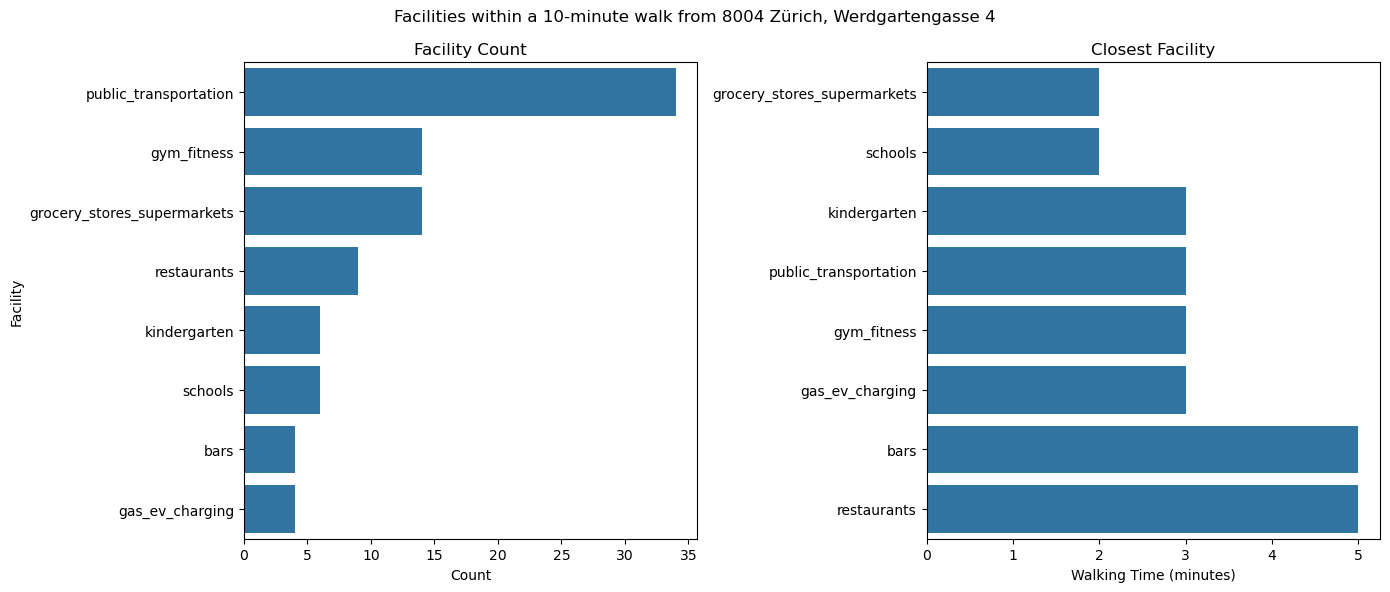

In [10]:
plot_data(facilities_data)

In [11]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 8004 Zürich, Werdgartengasse 4
Coordinates: (47.3711263, 8.5265537)

----------------------------------------

bars
--------------------
bars count: 4
Closest bars: Certo
Travel time to closest bars: 5 mins

place_id: ChIJnfoNvgQKkEcRt0g7rQ2msxY
name: Helvetia
rating: 4.4
num_ratings: 980
vicinity: Stauffacherquai 3, Zürich
location: {'lat': 47.37308059999999, 'lng': 8.5316546}
reviews: [{'author_name': 'Charles Woodward', 'author_url': 'https://www.google.com/maps/contrib/114886100071692529436/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocJ2owCXyj9bwPdIWJ9kq-FfIdUJXqC0dLKbbDiF-Z1ubSVjBQ=s128-c0x00000000-cc-rp-mo-ba2', 'rating': 4, 'relative_time_description': 'a week ago', 'text': 'Nice boutique hotel, very nice and accommodating staff, easy to walk to downtown, discounted parking at a nearby garage, clean, simple check in and out, on the

### Example 2

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32480978](https://en.comparis.ch/immobilien/marktplatz/details/show/32480978)

Address: 3027 Bern, Colombstrasse 39

Requests used:
- 557 Places API requests
- 29 Distance Matrix API

In [12]:
address = "3027 Bern, Colombstrasse 39"
facilities_data = get_facilities_data(address)

In [13]:
file_name = 'Ex2_3027_Bern_Colombstrasse_39.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [14]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,4,3.966667,5,Bits & Bites Bern,https://maps.google.com/?cid=18293575267401092066
restaurants,20,4.031579,3,Le Bistro - Westside,https://maps.google.com/?cid=15576324904411452826
kindergarten,20,4.011111,5,"Holiday Inn Bern - Westside, an IHG Hotel",https://maps.google.com/?cid=16360888693207591987
public_transportation,22,4.275000,3,Gäbelbach,https://maps.google.com/?cid=13447738710301340336
gym_fitness,14,4.108333,1,Fitness meets Beauty,https://maps.google.com/?cid=5836262558267539584
grocery_stores_supermarkets,18,4.105882,4,Migros-Supermarkt - Bern - Westside,https://maps.google.com/?cid=7257427116907477515
gas_ev_charging,12,4.063636,5,"Holiday Inn Bern - Westside, an IHG Hotel",https://maps.google.com/?cid=16360888693207591987
schools,3,4.666667,4,Clubhaus (Buvette) FC Bethlehem,https://maps.google.com/?cid=14756669744083869170


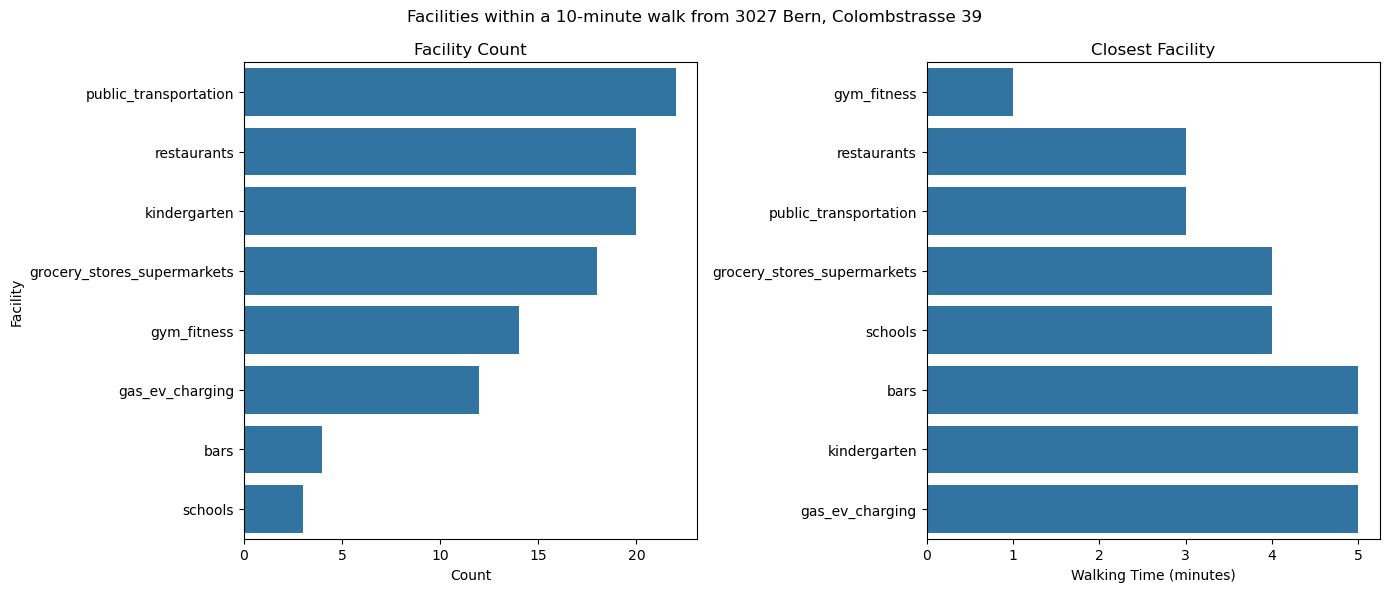

In [15]:
plot_data(facilities_data)

In [16]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 3027 Bern, Colombstrasse 39
Coordinates: (46.9455907, 7.3777487)

----------------------------------------

bars
--------------------
bars count: 4
Closest bars: Bits & Bites Bern
Travel time to closest bars: 5 mins

place_id: ChIJEyLdXCw5jkcR4ktQPcjV3_0
name: Bits & Bites Bern
rating: 4.4
num_ratings: 127
vicinity: Riedbachstrasse 96, Bern
location: {'lat': 46.94422089999999, 'lng': 7.374219699999998}
reviews: [{'author_name': 'Meritxell Costa', 'author_url': 'https://www.google.com/maps/contrib/108577532823173213183/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjWIjzTSzpgtdkWrYkHRYbSDkZ0N4nh8BB6FZZpSKbZwNxMUcM9Y=s128-c0x00000000-cc-rp-mo-ba4', 'rating': 5, 'relative_time_description': '7 months ago', 'text': 'This is an elegant place with a very good menu. In our case we tried the steak tartar (spicy). The vegetables were very tasty. The

### Example 3

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32480354](https://en.comparis.ch/immobilien/marktplatz/details/show/32480354)

Address: 1006 Lausanne, Av. d'Ouchy 58

Requests used:
- 907 Places API
- 52 Distance Matrix API

In [17]:
address = "1006 Lausanne, Av. d'Ouchy 58"
facilities_data = get_facilities_data(address)

In [18]:
file_name = 'Ex3_1006_Lausanne_Av_d_Ouchy_58.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [19]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,12,4.045455,1,White Horse,https://maps.google.com/?cid=10598199589679674991
restaurants,12,4.275000,1,Takayama. Sushi bar & restaurant,https://maps.google.com/?cid=6100830867409280438
kindergarten,22,4.318182,1,ImmoStreet.ch SA,https://maps.google.com/?cid=6443259497722280364
public_transportation,28,4.526087,1,ImmoStreet.ch SA,https://maps.google.com/?cid=6443259497722280364
gym_fitness,15,4.423077,1,ImmoStreet.ch SA,https://maps.google.com/?cid=6443259497722280364
grocery_stores_supermarkets,15,4.233333,1,ImmoStreet.ch SA,https://maps.google.com/?cid=6443259497722280364
gas_ev_charging,14,4.061538,1,ImmoStreet.ch SA,https://maps.google.com/?cid=6443259497722280364
schools,5,4.166667,2,"Formasuisse, Formations Rh, Management, Certif...",https://maps.google.com/?cid=17644539844706732708


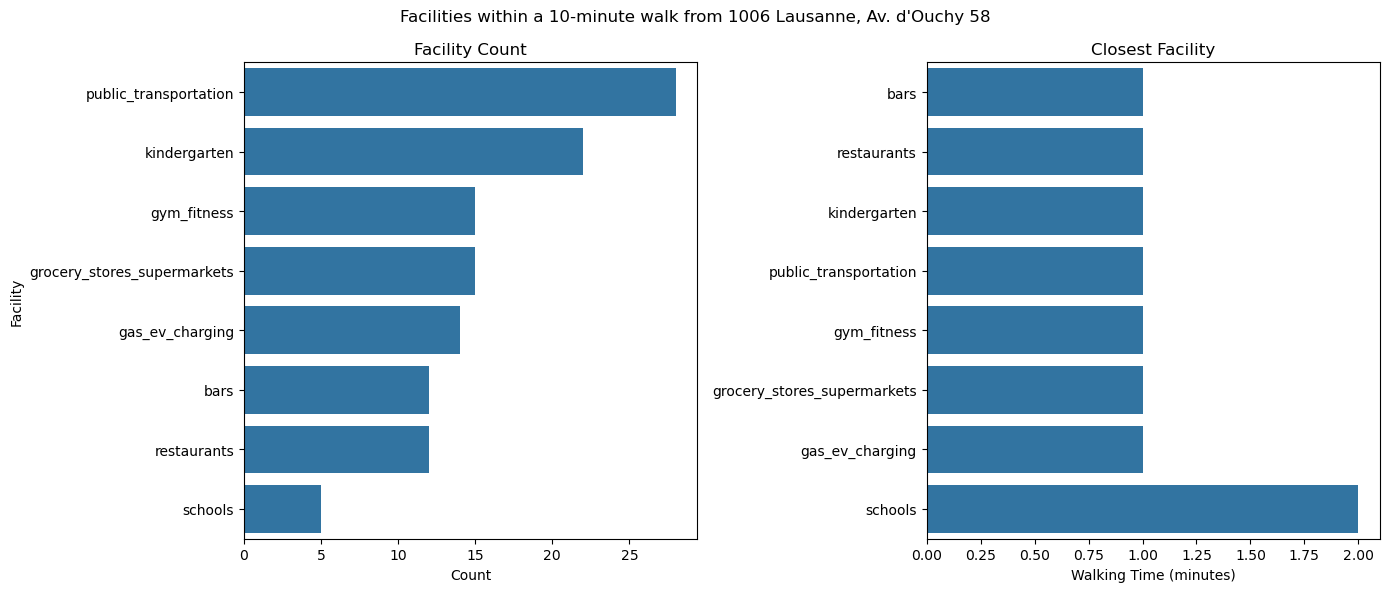

In [20]:
plot_data(facilities_data)

In [21]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 1006 Lausanne, Av. d'Ouchy 58
Coordinates: (46.5087576, 6.627395399999999)

----------------------------------------

bars
--------------------
bars count: 12
Closest bars: White Horse
Travel time to closest bars: 1 min

place_id: ChIJ9bsoo9ovjEcRdOP4ZuwTxbQ
name: Terrasse d'Ouchy
rating: 3.3
num_ratings: 539
vicinity: Place de la Navigation 1, Lausanne
location: {'lat': 46.5065699, 'lng': 6.625689599999999}
reviews: [{'author_name': 'Stella Esplosiva (Laura PeGr)', 'author_url': 'https://www.google.com/maps/contrib/116654088732073017954/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocJwAXke47AokJz0PB0fPqL8k4Pe1Ujved5CB7C0yMOCWPY_SA=s128-c0x00000000-cc-rp-mo-ba5', 'rating': 2, 'relative_time_description': 'a year ago', 'text': 'Restaurant in a very good location. It could be a lot more as the food is pretty good, but the service is very poor

### Example 4

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32476087](https://en.comparis.ch/immobilien/marktplatz/details/show/32476087)

Address: 8355 Aadorf, Bruggwiesenstrasse 5

Requests used:
- 558
- 32

In [22]:
address = "8355 Aadorf, Bruggwiesenstrasse 5"
facilities_data = get_facilities_data(address)

In [23]:
file_name = 'Ex4_8355_Aadorf_Bruggwiesenstrasse_5.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [24]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,3,4.800000,5.0,RotFarbKeller,https://maps.google.com/?cid=9287481811353943045
restaurants,5,4.525000,3.0,Ristorante El Capone,https://maps.google.com/?cid=2114056076748787776
kindergarten,28,4.655556,4.0,System-Clinch Telecom GmbH,https://maps.google.com/?cid=10231651174585185097
public_transportation,15,4.690000,4.0,System-Clinch Telecom GmbH,https://maps.google.com/?cid=10231651174585185097
gym_fitness,18,4.672727,4.0,System-Clinch Telecom GmbH,https://maps.google.com/?cid=10231651174585185097
grocery_stores_supermarkets,15,4.620000,4.0,System-Clinch Telecom GmbH,https://maps.google.com/?cid=10231651174585185097
gas_ev_charging,16,4.609091,4.0,System-Clinch Telecom GmbH,https://maps.google.com/?cid=10231651174585185097
schools,0,NaN,NaN,None,None


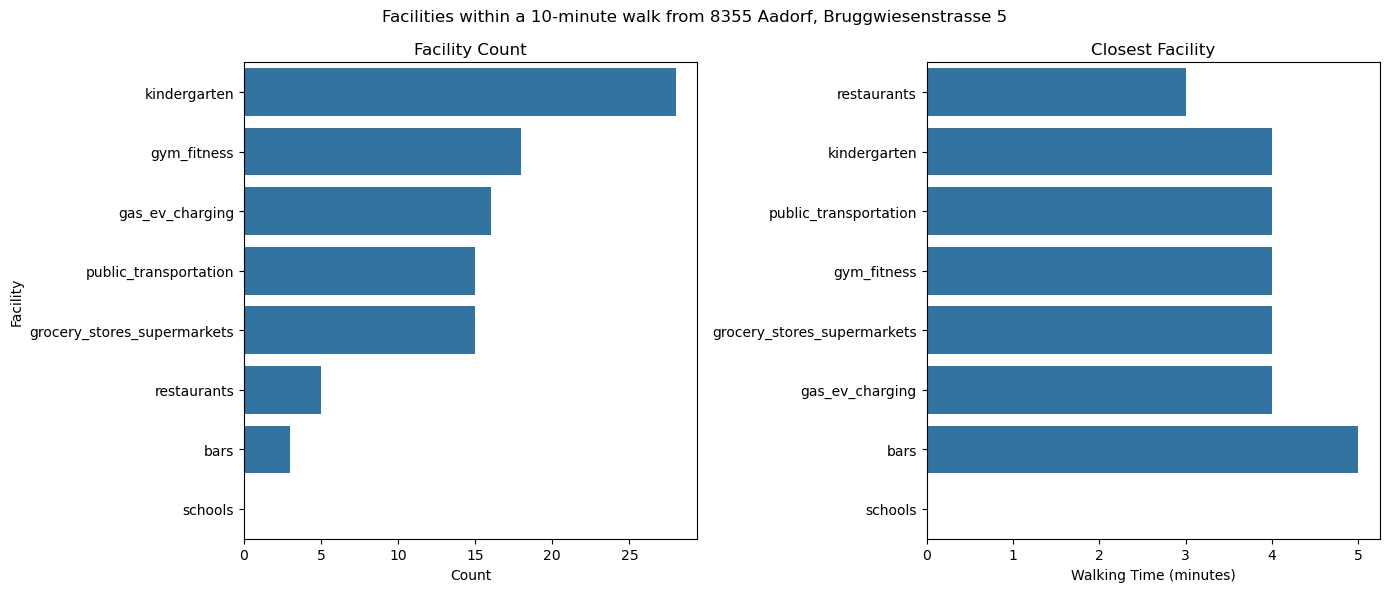

In [25]:
plot_data(facilities_data)

In [26]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 8355 Aadorf, Bruggwiesenstrasse 5
Coordinates: (47.4929713, 8.8935522)

----------------------------------------

bars
--------------------
bars count: 3
Closest bars: RotFarbKeller
Travel time to closest bars: 5 mins

place_id: ChIJ5delxJ2VmkcRBTynD4DD44A
name: RotFarbKeller
rating: 5
num_ratings: 11
vicinity: Hauptstrasse 47, Aadorf
location: {'lat': 47.4927474, 'lng': 8.894442399999999}
reviews: [{'author_name': 'Urs-Antoine Stöckli', 'author_url': 'https://www.google.com/maps/contrib/118018439785206900120/reviews', 'language': 'en-US', 'original_language': 'de', 'profile_photo_url': 'https://lh3.googleusercontent.com/a/ACg8ocI2zzZFyCFtBo_vUNeUmmLaA4Ar6Nj6uodPxmITxrh9nsm-aw=s128-c0x00000000-cc-rp-mo-ba5', 'rating': 5, 'relative_time_description': '3 years ago', 'text': 'Simply impressive and wonderful people who care about the artist and the art creation, support them and stand behind the project. Bravo to e

### Example 5

Ad: [https://en.comparis.ch/immobilien/marktplatz/details/show/32332137](https://en.comparis.ch/immobilien/marktplatz/details/show/32332137)

Address: 6319 Allenwinden, Winzrüti 39

Requests used:
- 439 Places API
- 38 Distance Matrix

In [27]:
address = "6319 Allenwinden, Winzrüti 39"
facilities_data = get_facilities_data(address)

In [28]:
file_name = 'Ex5_6319_Allenwinden_Winzruti_39.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [29]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,0,NaN,NaN,None,None
restaurants,1,NaN,9.0,Gasthaus Löwen,https://maps.google.com/?cid=14138526546025224052
kindergarten,18,4.90,4.0,Elektrizitäts-Genossenschaft,https://maps.google.com/?cid=11208224128477754040
public_transportation,14,4.92,4.0,Elektrizitäts-Genossenschaft,https://maps.google.com/?cid=11208224128477754040
gym_fitness,9,4.90,4.0,Elektrizitäts-Genossenschaft,https://maps.google.com/?cid=11208224128477754040
grocery_stores_supermarkets,9,4.90,4.0,Elektrizitäts-Genossenschaft,https://maps.google.com/?cid=11208224128477754040
gas_ev_charging,9,4.90,4.0,Elektrizitäts-Genossenschaft,https://maps.google.com/?cid=11208224128477754040
schools,0,NaN,NaN,None,None


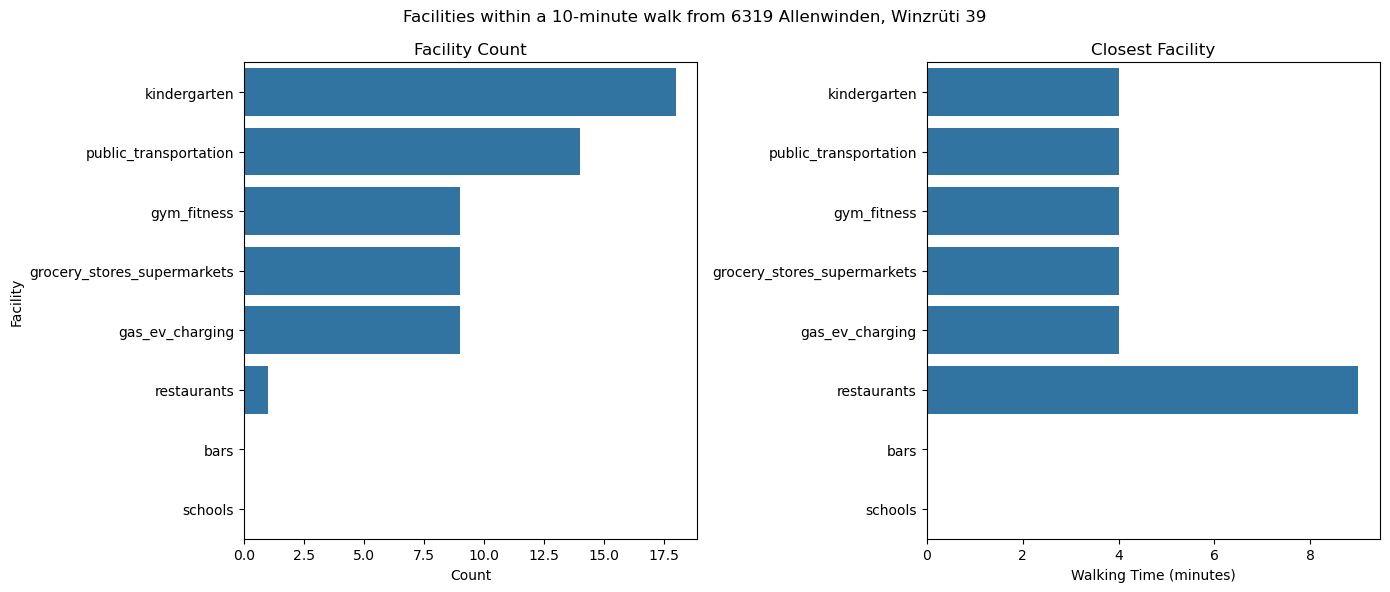

In [30]:
plot_data(facilities_data)

In [31]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 6319 Allenwinden, Winzrüti 39
Coordinates: (47.171282, 8.554959)

----------------------------------------

bars
--------------------
bars count: 0




restaurants
--------------------
restaurants count: 1
Closest restaurants: Gasthaus Löwen
Travel time to closest restaurants: 9 mins

place_id: ChIJ5SlvKXWrmkcRdJdDB_wiNsQ
name: Gasthaus Löwen
rating: 4.5
num_ratings: 59
vicinity: Dorfstrasse 35, Allenwinden
location: {'lat': 47.1666685, 'lng': 8.553291300000001}
reviews: [{'author_name': 'Nikos Karatzas', 'author_url': 'https://www.google.com/maps/contrib/114872466881577259344/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjXcgJ2e3XJYpRM0JIuw5A0_PhJinxRzjtreVvDhsb62llj91Q=s128-c0x00000000-cc-rp-mo', 'rating': 5, 'relative_time_description': '4 years ago', 'text': 'A very fine Gasthaus if one likes wild catch! Excellent cooking, friendly ser

## Example 6

Constructor Academy, Zurich

Address: 8005 Zürich, Heinrichstrasse 200

Requests used:
- 842 Places API
- 47 Distance Matrix API

In [32]:
address = "8005 Zürich, Heinrichstrasse 200"
facilities_data = get_facilities_data(address)

In [35]:
file_name = 'Ex6_8005_Zurich_Heinrichstrasse_200.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [34]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,13,4.261538,1,Don Weber,https://maps.google.com/?cid=10120145902270543587
restaurants,15,4.193333,1,Don Weber,https://maps.google.com/?cid=10120145902270543587
kindergarten,16,3.875000,4,Hotel Züri by Fassbind,https://maps.google.com/?cid=17891857237809814979
public_transportation,37,4.125926,3,Löwenbräu,https://maps.google.com/?cid=8255319773661372591
gym_fitness,16,4.135714,3,Body Mind Coaching,https://maps.google.com/?cid=1044040235407012299
grocery_stores_supermarkets,21,4.171429,1,Berg und Tal Viadukt,https://maps.google.com/?cid=10743680714392463231
gas_ev_charging,12,4.108333,1,Rigoni & Co,https://maps.google.com/?cid=3803131881136726289
schools,4,3.433333,3,Schulhaus Schütze,https://maps.google.com/?cid=11045677569546809057


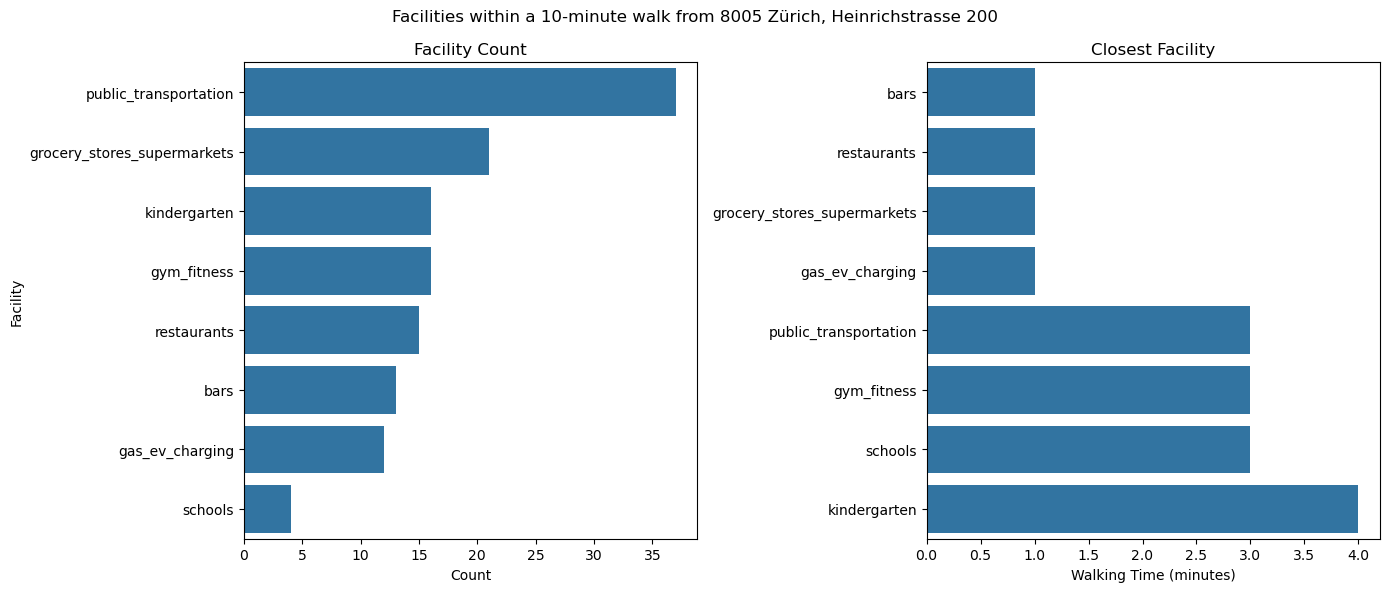

In [36]:
plot_data(facilities_data)

In [37]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 8005 Zürich, Heinrichstrasse 200
Coordinates: (47.3877722, 8.5254298)

----------------------------------------

bars
--------------------
bars count: 13
Closest bars: Don Weber
Travel time to closest bars: 1 min

place_id: ChIJWxeh7AAKkEcRkYBoJQ5gnJY
name: CLOUDS
rating: 4
num_ratings: 1954
vicinity: Maagplatz 5, Zürich
location: {'lat': 47.3860056, 'lng': 8.5171572}
reviews: [{'author_name': 'Raphael Zeller', 'author_url': 'https://www.google.com/maps/contrib/103372860829281358781/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjWSXzi8X3mppjFAGkynFWVDBK2rgSWRym0J31rFB6LZzIsfI6xw=s128-c0x00000000-cc-rp-mo-ba3', 'rating': 4, 'relative_time_description': '2 months ago', 'text': 'At CLOUDS, the view is the real star. The brunch on Sunday was diverse and varied.\nThe quality of the food was delicious and flavoursome. Not overcrowded, the select

## Example 7

Comparis Office, Zurich

Address: 8003 Zürich, Birmensdorferstrasse 108

Requests used:
- 812 Places API
- 42 Distance Matrix API

In [38]:
address = "8003 Zürich, Birmensdorferstrasse 108"
facilities_data = get_facilities_data(address)

In [39]:
file_name = 'Ex7_8003_Zurich_Birmensdorferstrasse_108.json'

with open(file_name, 'w') as file:
    json.dump(facilities_data, file, indent=4)

In [40]:
count_facilities(facilities_data)

,count,avg_rating,min_travel_time,closest_facility_name,closest_facility_url
bars,2,NaN,7,Plüsch,https://maps.google.com/?cid=12789023134786895310
restaurants,4,4.175000,8,Restaurant La Côte,https://maps.google.com/?cid=7730078061034110140
kindergarten,8,4.025000,3,Synagoge Agudas Achim,https://maps.google.com/?cid=12190515465346303875
public_transportation,37,3.804348,3,Synagoge Agudas Achim,https://maps.google.com/?cid=12190515465346303875
gym_fitness,13,4.258333,3,Synagoge Agudas Achim,https://maps.google.com/?cid=12190515465346303875
grocery_stores_supermarkets,12,4.133333,1,Lian Hua Wiedikon GmbH,https://maps.google.com/?cid=15330556608691964019
gas_ev_charging,5,3.940000,3,Synagoge Agudas Achim,https://maps.google.com/?cid=12190515465346303875
schools,4,3.933333,3,Schulhaus Aegerten,https://maps.google.com/?cid=11638125032438705925


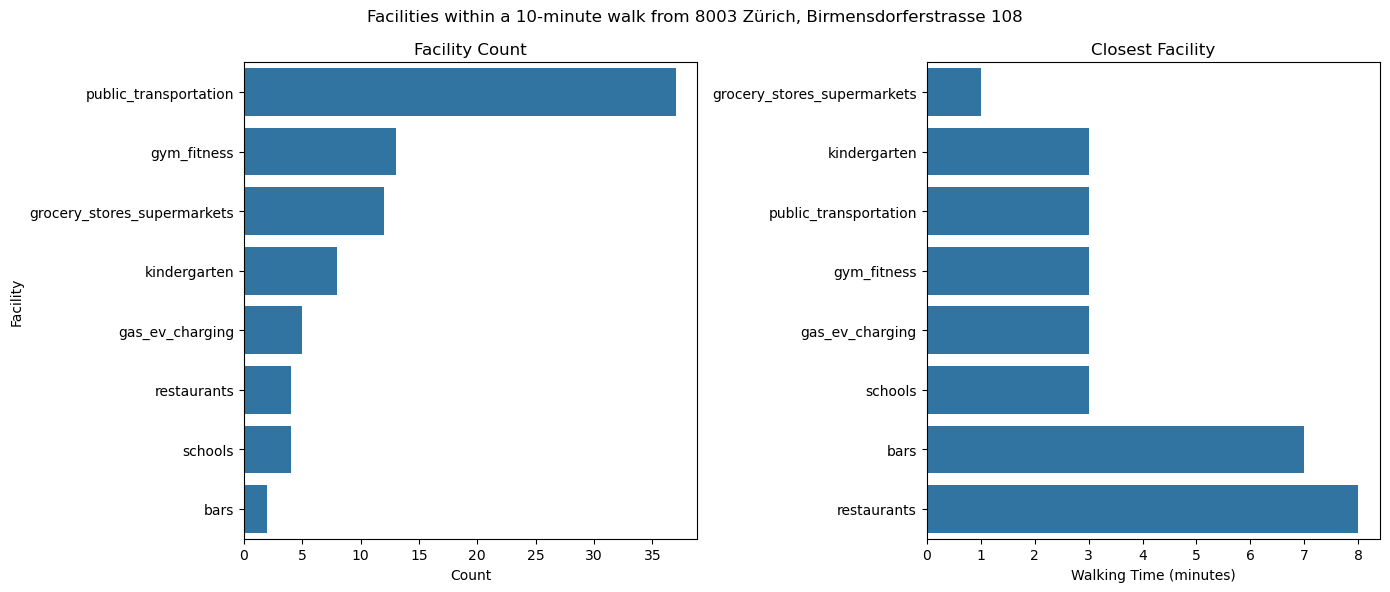

In [41]:
plot_data(facilities_data)

In [42]:
print_data(facilities_data)

Original Address Details:
----------------------------------------
Address: 8003 Zürich, Birmensdorferstrasse 108
Coordinates: (47.3706426, 8.521751799999999)

----------------------------------------

bars
--------------------
bars count: 2
Closest bars: Plüsch
Travel time to closest bars: 7 mins

place_id: ChIJmx-bphwKkEcRaYZra_sl-JY
name: Certo
rating: 4.4
num_ratings: 510
vicinity: Strassburgstrasse 5, Zürich
location: {'lat': 47.372212, 'lng': 8.528919}
reviews: [{'author_name': 'Mario Egger', 'author_url': 'https://www.google.com/maps/contrib/110112994712214535106/reviews', 'language': 'en', 'original_language': 'en', 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/ALV-UjU_1aAX7Gi-Slrcq-d4q61Q9Z4P-rxeDa8kqRKjzPxNCNK3kx2r=s128-c0x00000000-cc-rp-mo', 'rating': 5, 'relative_time_description': '7 months ago', 'text': 'We had an outstanding experience at the Certo restaurant in Zürich. The food was excellent, the service was friendly and the value for money was top-notch! H